<a href="https://colab.research.google.com/github/nebojsa-bozanic/BMI_OSuM/blob/master/Vezba6%3A%20Obrada%20rendgenske%20slike%3A%20Multiveli%C4%8Dinsko%20poja%C4%8Davanje%20strukture%20u%20slikama/OSuM_vezba_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Obrada slike u medicini (BMI)</h1>

Literatura: https://moodle.telekom.ftn.uns.ac.rs/course/view.php?id=82


Laboratorijska vežba 6: Obrada rendgenske slike: Multiveličinsko pojačavanje strukture u slikama

Potrebne biblioteke: cv2, numpy, matplotlib.pyplot, osum

In [1]:
!git clone https://github.com/nebojsa-bozanic/BMI_OSuM.git
%cd /content/BMI_OSuM/Vezba6: Obrada rendgenske slike: Multiveličinsko pojačavanje strukture u slikama

Cloning into 'BMI_OSuM'...
remote: Enumerating objects: 824, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 824 (delta 100), reused 125 (delta 57), pack-reused 606
Receiving objects: 100% (824/824), 273.52 MiB | 13.73 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Updating files: 100% (245/245), done.
/content/BMI_OSuM/Vezba6: Obrada rendgenske slike: Multiveličinsko pojačavanje strukture u slikama


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import osum

from google.colab.patches import cv2_imshow

1. Logaritamska kompresija opsega

1.1 Učitati sirovu sliku Ro_01.fxd koristeći funkciju read_raw iz modula osum.py.

In [3]:
[im, DetInfo, hdr] = osum.read_raw('Ro_01.fxd')

1.2 Napraviti LUT za logaritamsku kompresiju opsega tako da se ulazni opseg od 16384 pretvori u opseg 4096 sa tolerancijom 0.001. Primeniti LUT na ulaznu sliku i smestiti je u promenljivu im_log.

In [4]:
logLUT = osum.log_LUT(16384, 4096, 0.001)
im_log = logLUT[im]


1.3 Prikazati sliku nakon logaritamske kompresije.

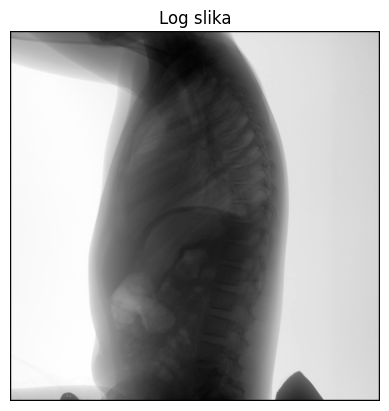

In [5]:
plt.imshow(im_log/im_log.max(), cmap='gray')
plt.axis('off')
plt.title('Log slika')
plt.show()

# 2. Multiveličinsko pojačavanje struktura

2.1 U modulu osum.py napraviti funkciju sigmLUT koja pravi sigmoidalnu transformaciju za pojačanje detalja Laplasove piramide. Ulazni parametri funkcije su ulazi opseg, izlazni opseg i nagib sigmoidalne funkcije.

2.2 Dekomponovati sliku im_log na Laplasovu piramidu od 6 nivoa.

In [6]:
LPyr, GPyr, Res = osum.im_pyr_decomp(im_log, 6)

2.3 Napraviti LUT koji se koristi za sigmoidalno pojačanje Laplasovih koeficijenata tako da je ulazni opseg -2000 do 2000, izlazni opseg -800 do 800, a faktor nagiba krive 4. Prikazati dobijeni LUT.

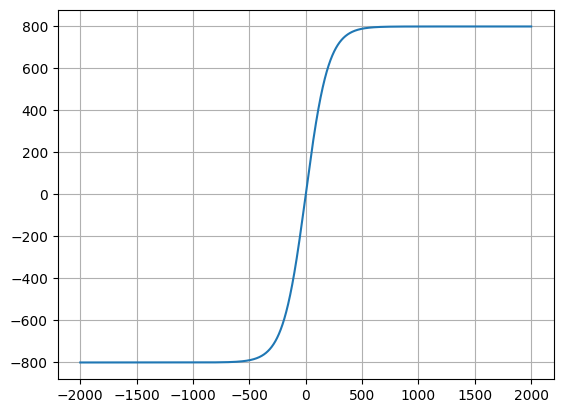

In [7]:
sigLUT = osum.sigmLUT(2000, 800, 4)
plt.figure()
plt.plot(np.arange(-2000, 2001), sigLUT)
plt.grid()
plt.show()

2.4 Primeniti LUT iz prethodnog koraka na treći nivo Laplasove piramide (LP) i smestiti ga u promenljivu Lk. Prikazati treći nivo LP pre i nakon transformacije.

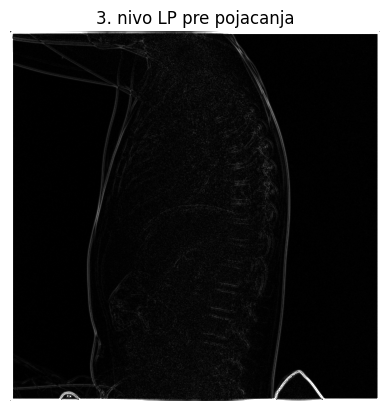

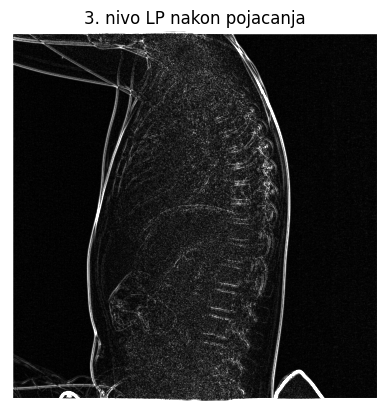

In [8]:
L3 = LPyr[2]
Lk = sigLUT[np.uint16(L3+2000)]

plt.figure()
plt.imshow(abs(L3), cmap='gray', vmin=abs(L3).min(), vmax=200)  # gornja granica 200 (analiza hist) da poboljsamo kontrast za prikaz
plt.axis('off')
plt.title('3. nivo LP pre pojacanja')
plt.figure()
plt.imshow(abs(Lk), cmap='gray', vmin=abs(L3).min(), vmax=200)
plt.axis('off')
plt.title('3. nivo LP nakon pojacanja')
plt.show()

2.5 Napraviti histogram trećeg nivoa LP u rasponu -500 do 501, pre i nakon sigmoidalne transformacije. Prikazati histograme na istom grafiku. Kako se razlikuju histogrami?

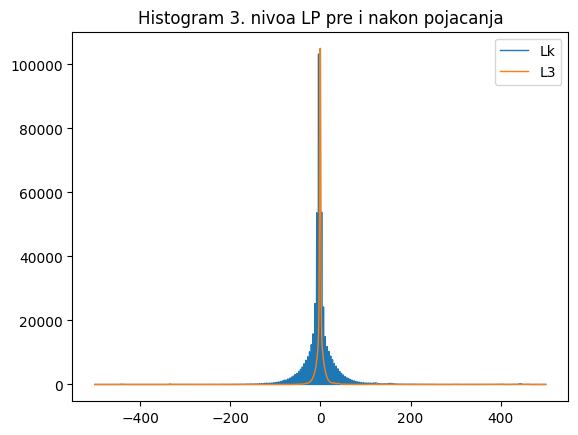

In [9]:
g = np.arange(-500, 502)
h1 = np.histogram(L3, g)
h2 = np.histogram(Lk, g)

plt.figure()
plt.plot(g[:-1], h2[0], linewidth=1)
plt.plot(g[:-1], h1[0], linewidth=1)
plt.legend(['Lk', 'L3'])
plt.title('Histogram 3. nivoa LP pre i nakon pojacanja')
plt.show()

2.6 Modifikovati rezidual u Res2 množenjem faktorom 0.7. Voditi računa da prosečni osvetljaj ostane isti.

In [10]:
res_mean = np.mean(Res)
Res2 = (Res-res_mean)*0.7+res_mean  # veci faktor -manje se smanjuju varijacije u intenzitetu

2.7 Rekonstruisati sliku koristeći LP na čijem se trećem nivou nalazi Lk i Res2. Prikazati rekonstruisanu sliku. Kako se razlikuju ova slika i im_log?

Text(0.5, 1.0, 'Nakon MSE')

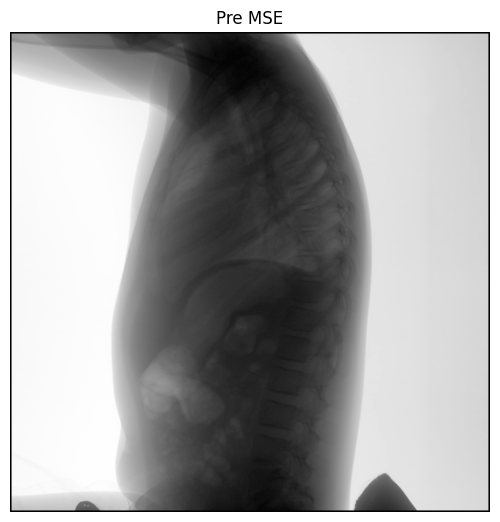

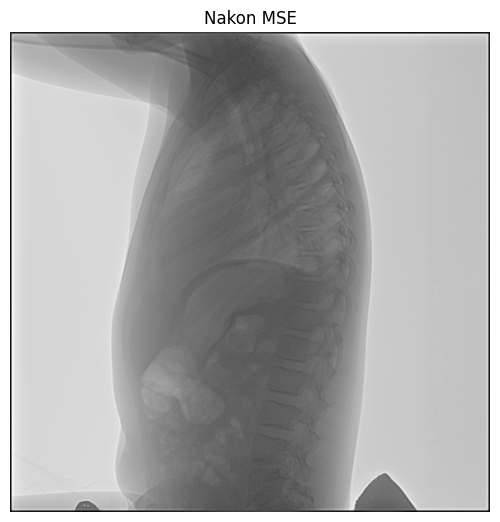

In [11]:
LPyr[2] = Lk
im_rec = osum.im_pyr_recon(LPyr, Res2)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(im_log, cmap='gray', vmin=im_log.min(), vmax=im_log.max())
plt.axis('off')
plt.title('Pre MSE')

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(im_rec, cmap='gray', vmin=im_rec.min(), vmax=im_rec.max())
plt.axis('off')
plt.title('Nakon MSE')


2.8 Isprobati prethodne korake na različitim nivoima LP (ili na više nivoa odjednom) i sa različitim faktorima k u sigmoidalnoj tranformaciji. Koji je efekat većeg, a koji manjeg k. Kako izgleda slika sa modifikovanim prvim, a kako sa petim nivoom LP?

# 3. Korekcija MTF-a

Modulation Transfer Function, prenosna funkcija digitalnog panela kojim je snimana slika, prikazan je na slici ispod. Veličina piksela je 139 μm, ekvivalentno maksimalnoj rezoluciji 3.6 lp/mm (para linija po milimetru). MFT panela je određen „Std CsI“ krivama.

3.1 Pretpostavljajući da je filter kojim radimo dekompoziciju piramide polu-opsežni, sračunati optimalne faktore pojačanja na svakom nivou piramide kako bi što bolje ispravili efekat MTF-a digitalnog panela u slici. Posmatrajte „Std CsI“ krive. Koje imaju vrednosti? Računati da je prosečan odziv u svakom opsegu vrednost MTF-a u sredini opsega. Kompenzujte njega pojačanjem da bude 1.

In [12]:
pojacanja = [1/0.13, 1/0.38, 1/0.68, 1/0.86, 1/0.94, 1/0.97]

3.2 Dekomponovati sliku im_log do 6. nivo veličine u Laplasovu piramidu i pojačati svaki nivo detalja adekvatnim faktorom pojačanja za korekciju MTF (da odziv u celom opsegu bude 1).

In [13]:
LPyr, GPyr, Res = osum.im_pyr_decomp(im_log, 6)

for i in range(0, len(LPyr)):
    sigmLUT = osum.sigmLUT(2000, 800, pojacanja[i])
    LPyr[i] = sigmLUT[np.uint16(LPyr[i]+2000)]

3.3 Rekonstruisati sliku sa pojačanim slikama detalja. Uporediti dobijenu sliku sa slikom im_log.

Text(0.5, 1.0, 'Nakon korekcije MTF-a')

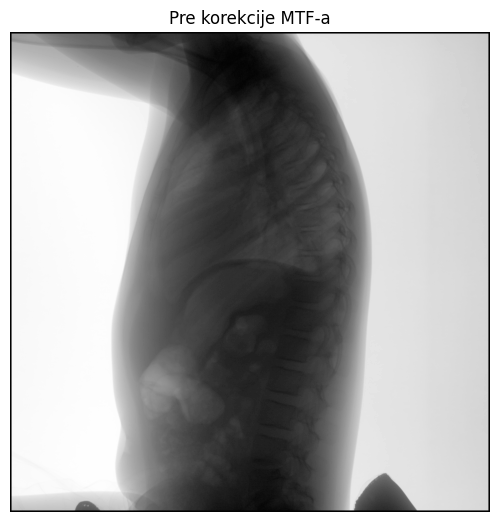

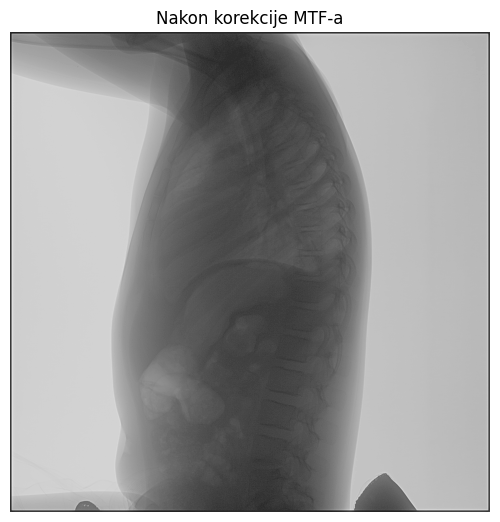

In [14]:
im_rec = osum.im_pyr_recon(LPyr, Res)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(im_log, cmap='gray', vmin=im_log.min(), vmax=im_log.max())
plt.axis('off')
plt.title('Pre korekcije MTF-a')

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(im_rec, cmap='gray', vmin=im_rec.min(), vmax=im_rec.max())
plt.axis('off')
plt.title('Nakon korekcije MTF-a')



3.4 Ponoviti korake 3.2 i 3.3 koristeći dodatno pojačanje na 4. i 5. nivou LP. Koji je efekat na rekonstruisanoj slici?

Text(0.5, 1.0, 'Nakon korekcije MTF-a')

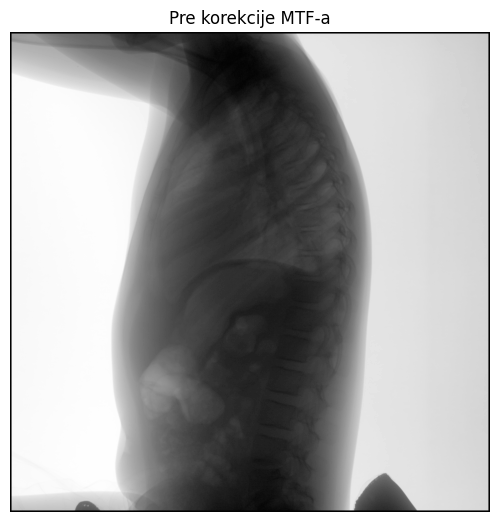

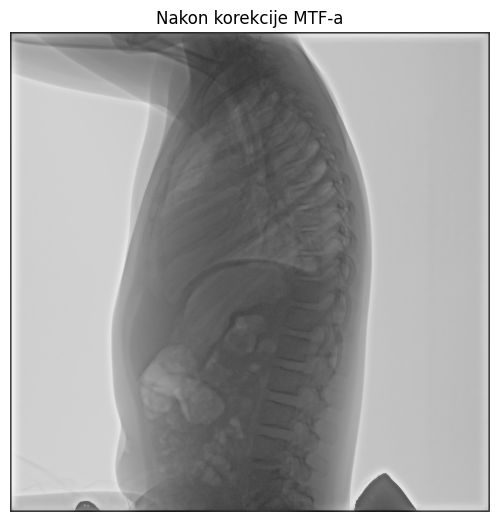

In [15]:
pojacanja = [1/0.13, 1/0.38, 1/0.68, 3/0.86, 3/0.94, 1/0.97]

LPyr, GPyr, Res = osum.im_pyr_decomp(im_log, 6)

for i in range(0, len(LPyr)):
    sigmLUT = osum.sigmLUT(2000, 800, pojacanja[i])
    LPyr[i] = sigmLUT[np.uint16(LPyr[i]+2000)]

    im_rec = osum.im_pyr_recon(LPyr, Res)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(im_log, cmap='gray', vmin=im_log.min(), vmax=im_log.max())
plt.axis('off')
plt.title('Pre korekcije MTF-a')

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(im_rec, cmap='gray', vmin=im_rec.min(), vmax=im_rec.max())
plt.axis('off')
plt.title('Nakon korekcije MTF-a')
